# Evaluating discovered update rules

This colab demonstrates how to instantiate the `Disco103` update rule and use it for training an RL agent on a jittable version of `Catch`.

The repository also contains `ActorCritic` and `PolicyGradient` update rules and a CPU version of `Catch`; feel free to explore and repurpose this code for your needs.

In [1]:
# @title Install the package.

# !pip install git+https://github.com/google-deepmind/disco_rl.git

import collections

import chex
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import rlax
import seaborn as sns
import tqdm

# Types & utils
from disco_rl import types
from disco_rl import utils

# Environments
from disco_rl.environments import base as base_env
from disco_rl.environments import jittable_envs

# Learning
from disco_rl import agent as agent_lib

axis_name = 'i'  # for parallelisation

In [3]:
# @title Download and unpack `Disco103` weights.

def unflatten_params(flat_params: chex.ArrayTree) -> chex.ArrayTree:
  params = {}
  for key_wb in flat_params:
    key = '/'.join(key_wb.split('/')[:-1])
    params[key] = {
        'b': flat_params[f'{key}/b'],
        'w': flat_params[f'{key}/w'],
    }
  return params


disco_103_fname = 'disco_103.npz'
disco_103_url = f"https://raw.githubusercontent.com/google-deepmind/disco_rl/main/disco_rl/update_rules/weights/{disco_103_fname}"
# !wget $disco_103_url

with open(f'/home/skr/Downloads/disco_rl/colabs/disco_103.npz', 'rb') as file:
  disco_103_params = unflatten_params(np.load(file))

print(f'Loaded {len(disco_103_params) * 2} parameter tensors for Disco103.')

Loaded 42 parameter tensors for Disco103.


In [4]:
# @title Instantiate a simple MLP agent.


def get_env(batch_size: int) -> base_env.Environment:
  return jittable_envs.CatchJittableEnvironment(
      batch_size=batch_size, env_settings=jittable_envs.get_config_catch()
  )


# Create a dummy environment.
env = get_env(batch_size=1)

# Create settings for an agent.
agent_settings = agent_lib.get_settings_disco()
agent_settings.net_settings.name = 'mlp'
agent_settings.net_settings.net_args = dict(
    dense=(512, 512),
    model_arch_name='lstm',
    head_w_init_std=1e-2,
    model_kwargs=dict(
        head_mlp_hiddens=(128,),
        lstm_size=128,
    ),
)
agent_settings.learning_rate = 1e-2

# Create the agent.
agent = agent_lib.Agent(
    agent_settings=agent_settings,
    single_observation_spec=env.single_observation_spec(),
    single_action_spec=env.single_action_spec(),
    batch_axis_name=axis_name,
)

# Ensure that the agent's update rule's parameters have the same specs.
random_update_rule_params, _ = agent.update_rule.init_params(
    jax.random.PRNGKey(0)
)
if agent_settings.update_rule_name == 'disco':
  chex.assert_trees_all_equal_shapes_and_dtypes(
      random_update_rule_params, disco_103_params
  )
  print('Update rule parameters have the same specs.')
else:
  print('Not using a discovered rule, skipping check.')

Update rule parameters have the same specs.


In [5]:
# @title Helper functions for interacting with environments.
def unroll_cpu_actor(
    params,
    actor_state,
    ts,
    env_state,
    rng,
    env,
    rollout_len,
    actor_step_fn,
    devices,
):
  """Unrolls the policy for a CPU environments."""
  actor_timesteps = []
  for _ in range(rollout_len):
    rng, step_rng = jax.random.split(rng)
    step_rng = jax.random.split(step_rng, len(devices))
    ts = utils.shard_across_devices(ts, devices)

    actor_timestep, actor_state = actor_step_fn(
        params, step_rng, ts, actor_state
    )
    actions = utils.gather_from_devices(actor_timestep.actions)
    env_state, ts = env.step(env_state, actions)

    actor_timesteps.append(actor_timestep)

  actor_rollout = types.ActorRollout.from_timestep(
      utils.tree_stack(actor_timesteps, axis=1)
  )
  return actor_rollout, actor_state, ts, env_state


def unroll_jittable_actor(
    params,
    actor_state,
    ts,
    env_state,
    rng,
    env,
    rollout_len,
    actor_step_fn,
    devices,
):
  """Unrolls the policy for a jittable environment."""
  del actor_step_fn, devices

  def _single_step(carry, step_rng):
    env_state, ts, actor_state = carry
    actor_timestep, actor_state = agent.actor_step(
        params, step_rng, ts, actor_state
    )
    env_state, ts = env.step(env_state, actor_timestep.actions)
    return (env_state, ts, actor_state), actor_timestep

  (env_state, ts, actor_state), actor_rollout = jax.lax.scan(
      _single_step,
      (env_state, ts, actor_state),
      jax.random.split(rng, rollout_len),
  )

  actor_rollout = types.ActorRollout.from_timestep(actor_rollout)
  return actor_rollout, actor_state, ts, env_state


def accumulate_rewards(acc_rewards, x):
  rewards, discounts = x

  def _step_fn(acc_rewards, x):
    rewards, discounts = x
    acc_rewards += rewards
    return acc_rewards * discounts, acc_rewards

  return jax.lax.scan(_step_fn, acc_rewards, (rewards, discounts))

In [6]:
# @title A simple Replay buffer.


class SimpleReplayBuffer:
  """A simple FIFO replay buffer for JAX arrays."""

  def __init__(self, capacity: int, seed: int):
    """Initializes the buffer."""
    self.buffer = collections.deque(maxlen=capacity)
    self.capacity = capacity
    self.np_rng = np.random.default_rng(seed)

  def add(self, rollout: types.ActorRollout) -> None:
    """Appends a batch of trajectories to the buffer."""
    rollout = jax.device_get(rollout)
    # split_tree = split_tree_on_dim(rollout, 2)
    split_tree = rlax.tree_split_leaves(rollout, axis=2)  # across batch dim
    self.buffer.extend(split_tree)

  def sample(self, batch_size: int) -> types.ActorRollout | None:
    """Samples a batch of trajectories from the buffer."""
    buffer_size = len(self.buffer)
    if buffer_size == 0:
      print("Warning: Trying to sample from an empty buffer.")
      return None

    indices = self.np_rng.integers(buffer_size, size=batch_size)
    batched_samples = utils.tree_stack(
        [self.buffer[i] for i in indices], axis=2
    )
    return batched_samples

  def __len__(self) -> int:
    """Returns the current number of transitions in the buffer."""
    return len(self.buffer)

In [9]:
# @title Training loop

num_steps = 1000
batch_size = 64
rollout_len = 29
rng_key = jax.random.PRNGKey(0)

replay_ratio = 32
buffer = SimpleReplayBuffer(capacity=1024, seed=17)
min_buffer_size = batch_size

num_envs = batch_size // replay_ratio
devices = tuple(jax.devices()[:num_envs])
env = get_env(num_envs)

# Init states.
env_state, ts = env.reset(rng_key)
acc_rewards = jnp.zeros((num_envs,))
learner_state = agent.initial_learner_state(rng_key)
actor_state = agent.initial_actor_state(rng_key)
update_rule_params = disco_103_params

# Parallelise training across all available devices.
actor_step_fn = jax.pmap(agent.actor_step, axis_name, devices=devices)
learner_step_fn = jax.pmap(
    agent.learner_step,
    axis_name=axis_name,
    devices=devices,
    static_broadcasted_argnums=(5,),
)
jitted_unroll_actor = jax.pmap(
    unroll_jittable_actor,
    axis_name=axis_name,
    devices=devices,
    static_broadcasted_argnums=(5, 6, 7, 8),
)
jitted_accumulate_rewards = jax.pmap(
    accumulate_rewards,
    axis_name=axis_name,
    devices=devices,
)

# Replicate onto the devices.
learner_state = jax.device_put_replicated(learner_state, devices)
actor_state = jax.device_put_replicated(actor_state, devices)
update_rule_params = jax.device_put_replicated(update_rule_params, devices)

is_jittable_actor = isinstance(
    env, jittable_envs.batched_jittable_env.BatchedJittableEnvironment
)

if is_jittable_actor:
  unroll_actor = jitted_unroll_actor
  acc_rewards_fn = jitted_accumulate_rewards
  acc_rewards = jnp.zeros((num_envs,))
  (env_state, ts, acc_rewards) = utils.shard_across_devices(
      (env_state, ts, acc_rewards), devices
  )
else:
  unroll_actor = unroll_cpu_actor
  acc_rewards_fn = accumulate_rewards

# Buffers.
all_metrics = []
all_rewards = []
all_discounts = []
all_steps = []
all_returns = []
total_steps = 0

# Run the loop.
for step in tqdm.tqdm(range(num_steps)):
  rng_key, rng_actor, rng_learner = jax.random.split(rng_key, 3)

  if is_jittable_actor:
    rng_actor = jax.random.split(rng_actor, len(devices))

  # Generate new trajectories and add them to the buffer.
  actor_rollout, actor_state, ts, env_state = unroll_actor(
      learner_state.params,
      actor_state,
      ts,
      env_state,
      rng_actor,
      env,
      rollout_len,
      actor_step_fn,
      devices,
  )
  buffer.add(actor_rollout)

  # Accumulate statistics.
  total_steps += np.prod(actor_rollout.rewards.shape)
  acc_rewards, returns = acc_rewards_fn(
      acc_rewards,
      (actor_rollout.rewards, actor_rollout.discounts),
  )
  all_steps.append(total_steps)
  all_rewards.append(jax.device_get(actor_rollout.rewards))
  all_discounts.append(jax.device_get(actor_rollout.discounts))
  all_returns.append(jax.device_get(returns))

  # Update agent's parameters on the samples from the buffer.
  rng_learner = jax.random.split(rng_learner, len(devices))
  if len(buffer) >= min_buffer_size:
    learner_rollout = buffer.sample(batch_size)
    learner_state, _, metrics = learner_step_fn(
        rng_learner,
        learner_rollout,
        learner_state,
        actor_state,
        update_rule_params,
        False,  # is_meta_training
    )
    all_metrics.append(jax.device_get(metrics))

# Collect all logs and statistics.
all_metrics, all_rewards, all_discounts, all_returns = (
    utils.gather_from_devices(
        (all_metrics, all_rewards, all_discounts, all_returns)
    )
)
(all_metrics,) = jax.tree.map(lambda x: x.mean(0), (all_metrics,))

100%|██████████| 1000/1000 [01:35<00:00, 10.42it/s]


In [10]:
# @title Process logs
all_returns = np.array(all_returns)
all_discounts = np.array(all_discounts)
all_steps = np.array(all_steps)
total_returns = (all_returns * (1 - all_discounts)).sum(axis=(1, 2))
total_episodes = (1 - all_discounts).sum(axis=(1, 2))
avg_returns = total_returns / total_episodes

padded_metrics = {}
pad_width = len(all_steps) - len(all_metrics)
for key in all_metrics[0].keys():
  values = np.array([m[key] for m in all_metrics])
  padded_metrics[key] = np.pad(values, (pad_width, 0), constant_values=np.nan)

df = pd.DataFrame(
    dict(
        steps=all_steps,
        avg_returns=avg_returns,
        **padded_metrics,
    )
)

df['name'] = agent_settings.update_rule_name

<Axes: xlabel='steps', ylabel='avg_returns'>

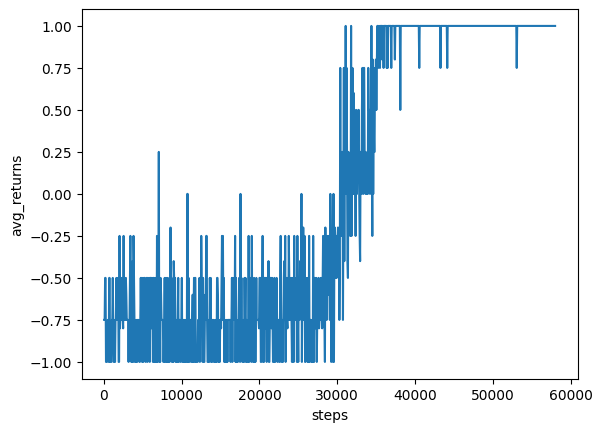

In [11]:
sns.lineplot(data=df, x='steps', y='avg_returns')